In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid,KFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

!pip install optuna
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from ipywidgets import IntProgress
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


# Load data

In [ ]:

DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


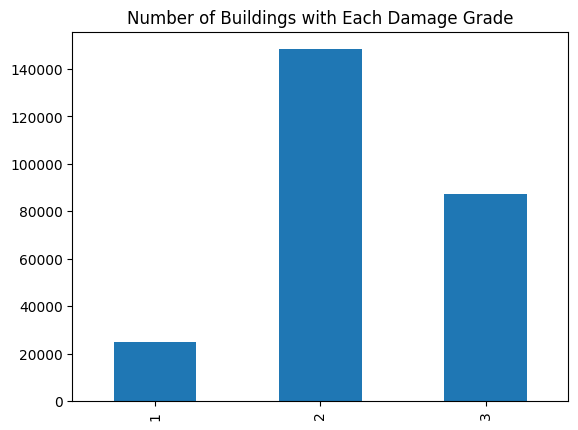

In [ ]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [ ]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Geo Embedding

In [ ]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [ ]:
# Step 1: Label Encoding
X = pd.concat([train_values, test_values]).loc[:,geo_features].drop_duplicates()

label_encoders = {}
encoded_data = {}

for column in X.columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(X[column])
    label_encoders[column] = le

encoded_df = pd.DataFrame(encoded_data)

input_data = torch.tensor(encoded_df.values, dtype=torch.long)
output_data = input_data.clone()

In [ ]:
for column in X.columns:
  print(X.loc[:, column].unique().size)

31
1418
11861


In [ ]:
# Step 2: Define the Neural Network

emb_dim = 32

class GeoEncoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_embedder = nn.Embedding(num_classes1, 8) #16
        self.geo_lv2_embedder = nn.Embedding(num_classes2, 16) #512
        self.geo_lv3_embedder = nn.Embedding(num_classes3, 32) #1024
        self.compressor = torch.nn.Linear(8+16+32, emb_dim)

    def forward(self, x):
        x_1 = self.geo_lv1_embedder(x[:, 0])
        x_2 = self.geo_lv2_embedder(x[:, 1])
        x_3 = self.geo_lv3_embedder(x[:, 2])
        x = torch.cat((x_1, x_2, x_3), dim=1)
        x = torch.nn.functional.relu(x)
        return self.compressor(x)

class GeoDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_predictor = nn.Linear(emb_dim, num_classes1)
        self.geo_lv2_predictor = nn.Linear(emb_dim, num_classes2)
        self.geo_lv3_predictor = nn.Linear(emb_dim, num_classes3)

    def forward(self, x):
        x1 = self.geo_lv1_predictor(x)
        x2 = self.geo_lv2_predictor(x)
        x3 = self.geo_lv3_predictor(x)
        return x1, x2, x3

class GeoEncoderDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.encoder = GeoEncoderModel(emb_dim, num_classes1, num_classes2, num_classes3)
        self.decoder = GeoDecoderModel(emb_dim, num_classes1, num_classes2, num_classes3)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.relu(x)
        x1, x2, x3 = self.decoder(x)
        return x1, x2, x3

In [ ]:
# Step 3: Training

# Create the neural network model
model = GeoEncoderDecoderModel().to(DEVICE)

batch_size = 512  # You can adjust this based on your available memory and computational resources
dataset = TensorDataset(input_data, output_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterions = []
for column in geo_features:
    weight = compute_class_weight('balanced',
                                  classes=X[column].unique(),
                                  y=X[column].values
    )
    weight = torch.tensor(weight, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight)
    criterions.append(criterion)

# Train the model
num_epochs = 500  # You can adjust this based on your data size and convergence
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 0
        for i in range(3):
          loss += criterions[i](outputs[i], targets[:,i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if ((epoch % 50 == 0) or (epoch == num_epochs -1)):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/500], Loss: 20.072901
Epoch [51/500], Loss: 0.300756
Epoch [101/500], Loss: 0.040670
Epoch [151/500], Loss: 0.012937
Epoch [201/500], Loss: 0.005307
Epoch [251/500], Loss: 0.002404
Epoch [301/500], Loss: 0.001147
Epoch [351/500], Loss: 0.000567
Epoch [401/500], Loss: 0.000283
Epoch [451/500], Loss: 0.000143
Epoch [500/500], Loss: 0.000074


In [ ]:
# Step 4: Extract the Embedding
# Now that the model is trained, you can get the embeddings for your original data

for df in [train_values, test_values]:
    encoded_data = {}

    for column in geo_features:
        le = label_encoders[column]
        encoded_data[column] = le.transform(df[column])

    encoded_df = pd.DataFrame(encoded_data)

    input_data = torch.tensor(encoded_df.values, dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        embedding = torch.relu(model.encoder(input_data))

    embedding = np.array(embedding.to('cpu'))

    for j in range(emb_dim):
        df ['geo_' + str(j+1)] = embedding[:,j]

    df.drop(columns=geo_features, inplace=True)

In [ ]:
train_values.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,geo_23,geo_24,geo_25,geo_26,geo_27,geo_28,geo_29,geo_30,geo_31,geo_32
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,6,5,t,r,n,f,q,t,...,9.275649,3.395608,16.316322,9.176401,22.406742,10.746646,8.195709,17.051559,4.908250,6.920246
28830,2,10,8,7,o,r,n,x,q,s,...,18.216463,9.031578,12.591386,4.548841,17.189018,18.887735,7.294501,16.728287,6.117009,4.759621
94947,2,10,5,5,t,r,n,f,x,t,...,6.889299,3.840760,9.917292,20.762587,12.846016,10.667956,7.845980,7.691974,22.427204,9.141951
590882,2,10,6,5,t,r,n,f,x,s,...,16.873472,9.149777,18.350254,7.718664,6.501131,5.383378,22.459951,13.625183,14.123244,1.249694
201944,3,30,8,9,t,r,n,f,x,s,...,14.233791,10.912489,13.223780,15.728879,16.249418,16.246346,12.870321,15.079964,16.931231,12.384354


In [ ]:
#torch.save(model.encoder.state_dict(), DIR + 'geo_embedding_32.pt')

# Search for best hyperparameters

In [ ]:
# Define an objective function for Optuna to optimize
def objective(trial):
    param_grid = {
        'objective': 'multi:softmax',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 200),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),
    }

    if DEVICE == "cuda":
        xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **param_grid)
    else:
        xgb_model = xgb.XGBClassifier(**param_grid)

    xgb_model.fit(X_train, y_train)

    pred_y_train = xgb_model.predict(X_train)
    train_score = f1_score(y_train, pred_y_train, average='micro')

    pred_y_val = xgb_model.predict(X_val)
    val_score = f1_score(y_val, pred_y_val, average='micro')

    return val_score  # Optuna tries to maximize F1 score on validation set

In [ ]:
# Define Train-Validation_Split and Optuna Optimizer
X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

study = optuna.create_study(direction='maximize')

[I 2023-09-03 17:58:09,827] A new study created in memory with name: no-name-3b567e67-5f64-41c8-8707-3d636dbbb77f


In [ ]:
# Search for best hyperparameter
study.optimize(objective, n_trials=100)  # adjust number of trials

[I 2023-09-03 18:00:36,143] Trial 0 finished with value: 0.7449780318873392 and parameters: {'n_estimators': 1352, 'learning_rate': 0.0822343910826066, 'max_depth': 11, 'min_child_weight': 45, 'min_split_loss': 0.5485886132141703, 'subsample': 0.6116619632336068, 'colsample_bytree': 0.891314693136121, 'colsample_bylevel': 0.9664087836281119, 'lambda': 0.4223324857440417, 'alpha': 0.5135898232978681}. Best is trial 0 with value: 0.7449780318873392.
[I 2023-09-03 18:00:58,851] Trial 1 finished with value: 0.7505611941443947 and parameters: {'n_estimators': 684, 'learning_rate': 0.09618181586175743, 'max_depth': 15, 'min_child_weight': 103, 'min_split_loss': 0.9954566246568147, 'subsample': 0.8532662932803485, 'colsample_bytree': 0.7317225190986576, 'colsample_bylevel': 0.6304118905035687, 'lambda': 0.780729036877759, 'alpha': 0.40056499445098404}. Best is trial 1 with value: 0.7505611941443947.
[I 2023-09-03 18:01:29,389] Trial 2 finished with value: 0.7509449166362887 and parameters: {'

In [ ]:
# Best hyperparameter (value = F1 score on validation set)
df = study.trials_dataframe()
df.sort_values(by='value', inplace=True, ascending=False)
df.drop(columns=['number', 'datetime_start', 'datetime_complete', 'duration', 'state']).head(10)

,value,params_alpha,params_colsample_bylevel,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_min_split_loss,params_n_estimators,params_subsample
64,0.752365,0.918199,0.626231,0.889825,0.010981,0.040076,12,154,0.215137,1440,0.728888
79,0.752211,0.862214,0.648878,0.828721,0.177949,0.035196,13,156,0.090741,1342,0.714327
87,0.752058,0.941481,0.603267,0.808171,0.002819,0.047534,12,114,0.034045,1329,0.695642
91,0.752000,0.939054,0.640743,0.793198,0.103320,0.044075,12,128,0.021498,1261,0.661178
86,0.751981,0.973907,0.683577,0.808341,0.107776,0.040189,13,113,0.024704,1405,0.733792
51,0.751808,0.841108,0.634053,0.900421,0.190989,0.041285,14,186,0.135966,1337,0.682151
66,0.751751,0.911398,0.609119,0.881049,0.052330,0.040215,12,141,0.129635,1500,0.715991
67,0.751732,0.785238,0.613091,0.879716,0.037350,0.040333,11,137,0.047885,1470,0.715959
45,0.751732,0.828079,0.622074,0.814088,0.302617,0.043170,12,114,0.204716,1191,0.678130
53,0.751655,0.847512,0.666032,0.896789,0.255245,0.038114,14,165,0.153267,1304,0.648950


In [ ]:
# Choose 5 best parameter
best_param_list = []
for i in range(5):
  trial_nr = df.iloc[i,:].loc['number']
  params = study.trials[trial_nr].params
  params['objective'] = 'multi:softmax'
  params['random_state'] = 42
  best_param_list.append(params)

In [ ]:
# Cross validation for 5 best params

X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

f = IntProgress(min=0, max=5* len(best_param_list)) #progress bar
display(f)

for i, params in enumerate(best_param_list):
    train_scores = []
    val_scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        if DEVICE == "cuda":
          xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
        else:
          xgb_model = xgb.XGBClassifier(**params)
        xgb_model.fit(X_train, y_train)

        train_y_pred = xgb_model.predict(X_train)
        train_scores.append(f1_score(y_train, train_y_pred, average='micro'))

        val_y_pred = xgb_model.predict(X_test)
        val_scores.append(f1_score(y_test, val_y_pred, average='micro'))

        f.value += 1

    df = pd.DataFrame(data=params, index = [i])
    df['train_score'] = np.mean(train_scores)
    df['val_score'] = np.mean(val_scores)
    results.append(df)

IntProgress(value=0, max=25)

In [ ]:
df_results = pd.concat(results)
df_results.sort_values(by='val_score', inplace=True, ascending=False)
df_results.drop(columns=['objective', 'random_state'])

,n_estimators,learning_rate,max_depth,min_child_weight,min_split_loss,subsample,colsample_bytree,colsample_bylevel,lambda,alpha,train_score,val_score
3,1261,0.044075,12,128,0.021498,0.661178,0.793198,0.640743,0.103320,0.939054,0.806648,0.751851
0,1440,0.040076,12,154,0.215137,0.728888,0.889825,0.626231,0.010981,0.918199,0.807050,0.751824
1,1342,0.035196,13,156,0.090741,0.714327,0.828721,0.648878,0.177949,0.862214,0.802817,0.751686
4,1405,0.040189,13,113,0.024704,0.733792,0.808341,0.683577,0.107776,0.973907,0.822151,0.751586
2,1329,0.047534,12,114,0.034045,0.695642,0.808171,0.603267,0.002819,0.941481,0.816971,0.751444


In [ ]:
best_params = df_results.drop(columns=['train_score', 'val_score']).to_dict('records')[0]

# Final training and prediction

In [ ]:
X_train = pd.get_dummies(train_values)
X_test = pd.get_dummies(test_values)
y_train = train_labels.values.ravel() - 1

if DEVICE == "cuda":
    xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
else:
    xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

pred_y_train = xgb_model.predict(X_train)
train_score = f1_score(y_train, pred_y_train, average='micro')
print('training score: {0: .5f}'.format(train_score))

training score:  0.80490


In [ ]:
predictions = xgb_model.predict(X_test) + 1

# Save submission

In [ ]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission.to_csv(DIR+'submissions/submission_geo_embedding2.csv')